In [ ]:
# importing libraries
!pip install tensorflow
!pip install -q -U keras-tuner
import keras_tuner as kt
from google.colab import drive
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import datetime

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
# from keras.optimizers import adam_v2 # from keras.optimizers import adam_v2
from tensorflow.keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint

import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# mounting drive to colab to load files
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# upgrading gensim
!pip install --upgrade gensim

     |████████████████████████████████| 24.1 MB 1.4 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [ ]:
# installing tensorflow
!pip install tensorflow

In [ ]:
vocabulary = dict()
# loading pretrained word embeddings corpura
EMBEDDING_FILE = '/content/drive/MyDrive/GoogleNews-vectors-negative300.bin.gz'
FAST_TEXT_EMBEDDING_FILE = '/content/drive/MyDrive/crawl-300d-2M.vec'
MODEL_SAVING_DIR = '/home/ecohen/HDD/HDD4/Models/Kaggle/Quora/'

In [ ]:
# Loading dataset
df = pd.read_csv("/content/drive/MyDrive/quora_duplicate_questions.tsv", sep='\t')
train_df = pd.read_csv("/content/drive/MyDrive/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/test.csv")
df.info()
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 404287 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404287 non-null  int64 
 1   qid1          404287 non-null  int64 
 2   qid2          404287 non-null  int64 
 3   question1     404287 non-null  object
 4   question2     404287 non-null  object
 5   is_duplicate  404287 non-null  int64 
dtypes: int64(4), object(2)
memory usage:

In [ ]:
# viewing training data for reference
df.head()


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
# # df.drop("Unnamed: 0", axis=1, inplace=True)
train_df = train_df.iloc[: , 1:]
train_df.head()


,id,qid1,qid2,question1,question2,is_duplicate
0,320527,61613,193949,Where can I watch movies online?,What is the best site to watch free movies onl...,1
1,397954,531142,531143,How do you climb the corporate ladder?,How do I climb the corporate ladder?,1
2,177654,273043,273044,What are the options available for MS in Infor...,Do you think the world would be better in cave...,0
3,137348,29425,151036,Is iPhone 7 worth the price?,Is it worth to buy an iPhone 7?,1
4,310064,434129,434130,How do you start your new Android project?,How do Android projects get started?,0


In [ ]:
test_df = test_df.iloc[: , 1:]
test_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,272227,78230,14209,What are some major social faux pas to avoid w...,What are some major social faux pas to avoid w...,0
1,319872,445359,126618,Can we believe in ghosts?,Do you believe in ghosts?,0
2,358672,49078,15605,What is the best TV series and why?,Which is the best TV series you have ever watc...,1
3,346293,474646,474647,Are girls booked in advance for horny birds vi...,What are the best websites with free photos of...,0
4,10773,20846,20847,Uber (company): How can you estimate an Uber f...,Is there a way to estimate a Lyft or Uber fare...,0


In [ ]:
stops = set(stopwords.words('english'))

def question_preprocessing(text):
    ''' Pre process and convert questions to a list of words '''
    text = str(text)
    text = text.lower()

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    text = text.split()

    return text


In [ ]:
# Prepare embedding

# '<unk>' will never be used, it is only a placeholder for the [0, 0, ....0] embedding
googleword2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
# fasttextword2vec=KeyedVectors.load_word2vec_format(FAST_TEXT_EMBEDDING_FILE)

In [ ]:
def question_to_num(word2vec):

    inverse_vocabulary = ['<unk>']
    questions_cols = ['question1', 'question2']

    # Iterate over the questions only of both training and test datasets
    for dataset in [train_df,test_df]:

      for index, row in dataset.iterrows():

          # Iterate through the text of both questions of the row
          for question in questions_cols:

              q2n = []  # q2n -> question numbers representation
              for word in question_preprocessing(row[question]):

                  # Check for unwanted words
                  if word in stops and word not in word2vec.key_to_index:
                      continue

                  if word  not in vocabulary:
                      vocabulary[word] = len(inverse_vocabulary)
                      q2n.append(len(inverse_vocabulary))
                      inverse_vocabulary.append(word)
                  else:
                      q2n.append(vocabulary[word])

              # Replace questions as word to question as number representation
              dataset.at[index,question]=q2n
                
    embedding_dim = 300
    embeddings = 1 * np.random.randn(len(vocabulary) + 1, embedding_dim)  # This will be the embedding matrix
    embeddings[0] = 0  # So that the padding will be ignored

    # Build the embedding matrix
    for word, index in vocabulary.items():
        if word in word2vec.key_to_index:
            embeddings[index] = word2vec.word_vec(word)

    del word2vec
    return embeddings

In [ ]:
embeddings=question_to_num(googleword2vec)
# print(df.isna().sum())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).


In [ ]:
test_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,272227,78230,14209,"[7, 19, 188, 2108, 1280, 6516, 6517, 893, 128,...","[7, 19, 188, 2108, 1280, 6516, 6517, 893, 128,...",0
1,319872,445359,126618,"[2, 444, 989, 24, 6682]","[14, 15, 989, 24, 6682]",0
2,358672,49078,15605,"[7, 8, 9, 10, 770, 771, 252]","[70, 8, 9, 10, 770, 771, 15, 159, 96, 772]",1
3,346293,474646,474647,"[19, 145, 7937, 24, 1899, 22, 10973, 4401, 372]","[7, 19, 9, 10, 834, 78, 12, 2179, 8078, 617, 6...",0
4,10773,20846,20847,"[4626, 415, 508, 13, 2, 15, 4227, 53, 4626, 21...","[8, 114, 116, 4227, 7399, 39, 4626, 2112, 24, ...",0


In [ ]:
# train_df, test_df = train_test_split(df, test_size=0.2)
# max_seq_length = max(train_df.question1.map(lambda x: len(x)).max(),
#                      train_df.question2.map(lambda x: len(x)).max(),
#                      test_df.question1.map(lambda x: len(x)).max(),
#                      test_df.question2.map(lambda x: len(x)).max())

max_seq_length=20
questions_cols = ['question1', 'question2']

# Split to train validation
validation_size = 40000
training_size = len(train_df) - validation_size

X = train_df[questions_cols]
Y = train_df['is_duplicate']

X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size)

# Split to dicts
X_train = {'input_1': X_train.question1, 'input_2': X_train.question2}
X_validation = {'input_1': X_validation.question1, 'input_2': X_validation.question2}
X_test = {'input_1': test_df.question1, 'input_2': test_df.question2}


# Convert labels to their numpy representations
Y_train = Y_train.values
Y_validation = Y_validation.values

# Zero padding
for dataset, side in itertools.product([X_train, X_validation], ['input_1', 'input_2']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Zero padding
for dataset, side in itertools.product([X_train, X_test], ['input_1', 'input_2']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)

# Make sure everything is ok
assert X_train['input_1'].shape == X_train['input_2'].shape
assert len(X_train['input_1']) == len(Y_train)

In [ ]:
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import Adam

In [ ]:
# Model variables
n_hidden = 60
gradient_clipping_norm = 1.25
batch_size = 64
n_epoch = 30
# n_epoch = 1
def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))
def build_model(hp):
    # The visible layer
  left_input = Input(shape=(max_seq_length,), dtype='int32')
  right_input = Input(shape=(max_seq_length,), dtype='int32')

  embedding_layer = Embedding(len(embeddings), 300, weights=[embeddings], input_length=max_seq_length, trainable=False)

  # Embedded version of the inputs
  encoded_left = embedding_layer(left_input)
  encoded_right = embedding_layer(right_input)

  # Since this is a siamese network, both sides share the same LSTM
  shared_lstm = LSTM(hp.Int('input_unit',min_value=32,max_value=512,step=32))

  left_output = shared_lstm(encoded_left)
  right_output = shared_lstm(encoded_right)

  # Calculates the distance as defined by the MaLSTM model
  malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

  # Pack it all up into a model
  malstm = Model([left_input, right_input], [malstm_distance])

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  # Adadelta optimizer, with gradient clipping by norm
  optimizer = Adam(learning_rate=hp_learning_rate)

  malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])
  return malstm


In [ ]:
# HyperBand algorithm from keras tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=25,
    directory='/content/drive/MyDrive/keras_tuner_dir',
    project_name='keras_tuner_demo', overwrite=True
)

In [ ]:
tuner.search([X_train['input_1'], X_train['input_2']], Y_train, epochs=6, validation_data=(X_validation, Y_validation))


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
128               |?                 |input_unit
0.01              |?                 |learning_rate

Epoch 1/6
8858/8858 [==============================] - 711s 80ms/step - loss: 0.2072 - accuracy: 0.7094 - val_loss: 0.2025 - val_accuracy: 0.7186
Epoch 2/6
7335/8858 [=======================>......] - ETA: 1:56 - loss: 0.2020 - accuracy: 0.7194

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

IndexError: ignored

In [ ]:
# Model variables
n_hidden = 128
gradient_clipping_norm = 1.25
batch_size = 64
# n_epoch = 25
n_epoch = 10
def exponent_neg_manhattan_distance(left, right):
    ''' Helper function for the similarity estimate of the LSTMs outputs'''
    return K.exp(-K.sum(K.abs(left-right), axis=1, keepdims=True))

# The visible layer
left_input = Input(shape=(max_seq_length,), dtype='int32')
right_input = Input(shape=(max_seq_length,), dtype='int32')

embedding_layer = Embedding(len(embeddings), 300, weights=[embeddings], input_length=max_seq_length, trainable=False)

# Embedded version of the inputs
encoded_left = embedding_layer(left_input)
encoded_right = embedding_layer(right_input)

# Since this is a siamese network, both sides share the same LSTM
shared_lstm = LSTM(n_hidden)

left_output = shared_lstm(encoded_left)
right_output = shared_lstm(encoded_right)

# Calculates the distance as defined by the MaLSTM model
malstm_distance = Lambda(function=lambda x: exponent_neg_manhattan_distance(x[0], x[1]),output_shape=lambda x: (x[0][0], 1))([left_output, right_output])

# Pack it all up into a model
malstm = Model([left_input, right_input], [malstm_distance])

# Adadelta optimizer, with gradient clipping by norm
optimizer = Adam(learning_rate=0.0001)

malstm.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy'])

# Start training
training_start_time = time()

malstm_trained = malstm.fit([X_train['input_1'], X_train['input_2']], Y_train, batch_size=batch_size, epochs=n_epoch,
                            validation_data=([X_validation['input_1'], X_validation['input_2']], Y_validation))

print("Training time finished.\n{} epochs in {}".format(n_epoch, datetime.timedelta(seconds=time()-training_start_time)))

Epoch 1/10
4429/4429 [==============================] - 42s 8ms/step - loss: 0.1983 - accuracy: 0.7184 - val_loss: 0.1757 - val_accuracy: 0.7435
Epoch 2/10
4429/4429 [==============================] - 37s 8ms/step - loss: 0.1706 - accuracy: 0.7561 - val_loss: 0.1664 - val_accuracy: 0.7608
Epoch 3/10
4429/4429 [==============================] - 35s 8ms/step - loss: 0.1626 - accuracy: 0.7704 - val_loss: 0.1607 - val_accuracy: 0.7735
Epoch 4/10
4429/4429 [==============================] - 38s 9ms/step - loss: 0.1572 - accuracy: 0.7801 - val_loss: 0.1567 - val_accuracy: 0.7783
Epoch 5/10
4429/4429 [==============================] - 36s 8ms/step - loss: 0.1530 - accuracy: 0.7873 - val_loss: 0.1536 - val_accuracy: 0.7865
Epoch 6/10
4429/4429 [==============================] - 36s 8ms/step - loss: 0.1498 - accuracy: 0.7928 - val_loss: 0.1511 - val_accuracy: 0.7893
Epoch 7/10
4429/4429 [==============================] - 37s 8ms/step - loss: 0.1472 - accuracy: 0.7967 - val_loss: 0.1494 - val_ac

In [ ]:
malstm.save('/content/drive/MyDrive/AIproj/my_models/google')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/AIproj/my_models/google/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/AIproj/my_models/google/assets


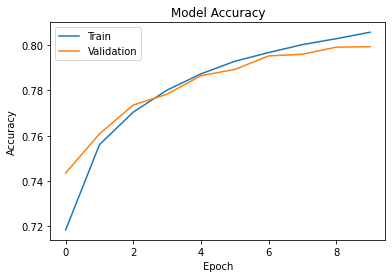

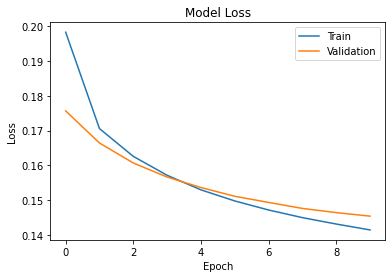

In [ ]:
# Plot accuracy
plt.plot(malstm_trained.history['accuracy'])
plt.plot(malstm_trained.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(malstm_trained.history['loss'])
plt.plot(malstm_trained.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
# from sklearn.metrics import accuracy_score
# joblib.dump(malstm_trained, '/content/drive/MyDrive/AIproj/histories/googlehistory')

In [ ]:
from tensorflow import keras
abc = keras.models.load_model('/content/drive/MyDrive/AIproj/my_models/google')

In [ ]:
for dataset, side in itertools.product([X_test], ['input_1', 'input_2']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)
Y_test=test_df['is_duplicate'].values
res=malstm.predict(X_test)
print(res)


[[0.01534823]
 [0.8094978 ]
 [0.65252423]
 ...
 [0.05483447]
 [0.20345806]
 [0.62131786]]


In [ ]:
import numpy
numpy.savetxt("/content/drive/MyDrive/AIproj/gw2c.csv", res, delimiter=",")

In [ ]:
# res=malstm.predict([X_test['input_1'], X_test['input_2']])
# print(res)
a=[]
for i in res:
  if i>0.5:
    a.append(1)
  else:
    a.append(0)
print(a)


[0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 

In [ ]:
from sklearn.metrics import accuracy_score
accuracyyy=accuracy_score(Y_test,a,normalize=True)
print(accuracyyy)

0.7958643547948255


In [ ]:
for dataset, side in itertools.product([X_test], ['input_1', 'input_2']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)
Y_test=test_df['is_duplicate'].values
res=abc.predict(X_test)
print(res)
# res=malstm.predict([X_test['input_1'], X_test['input_2']])
# print(res)
a=[]
for i in res:
  if i>0.5:
    a.append(1)
  else:
    a.append(0)
print(a)
from sklearn.metrics import accuracy_score
accuracyyy=accuracy_score(Y_test,a,normalize=True)
print(accuracyyy)


[[0.07270403]
 [0.73573506]
 [0.6535303 ]
 ...
 [0.0268125 ]
 [0.21987022]
 [0.6897395 ]]
[0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
matrix1 = confusion_matrix(Y_test,a, labels=[1,0])
print(matrix1)


[[19614 10263]
 [ 6115 44866]]


In [ ]:
matrix2 = classification_report(Y_test,a,labels=[1,0])
print(matrix2)

              precision    recall  f1-score   support

           1       0.76      0.66      0.71     29877
           0       0.81      0.88      0.85     50981

    accuracy                           0.80     80858
   macro avg       0.79      0.77      0.78     80858
weighted avg       0.79      0.80      0.79     80858



TypeError: ignored

In [ ]:
for dataset, side in itertools.product([X_test], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side], maxlen=max_seq_length)
Y_test=test_df['is_duplicate'].values
results = malstm.evaluate([X_test['left'], X_test['right']],test_df['is_duplicate'].values, batch_size=batch_size)
print("test loss, test acc:", results)

1264/1264 [==============================] - 16s 12ms/step - loss: 0.2254 - accuracy: 0.6824
test loss, test acc: [0.2254052758216858, 0.6823814511299133]


In [ ]:
preds=malstm.predict([X_test['left'],X_test['right']])

In [ ]:
fin=[]
# print(preds)
for i in preds:
  if i>0.5:
    fin.append(1)
  else:
    fin.append(0)
# preds[results>0.5]=1
# preds[results<=0.5]=0
print(fin)
test_df['preddd']=fin


[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 

In [ ]:
# acc=[]
test_df.head()
# test_df['new'] = np.where((test_df['is_duplicate'].values == df['preddd'].values) , df['is_duplicate'], np.nan)

,id,qid1,qid2,question1,question2,is_duplicate,preddd
0,272227,78230,14209,"[1, 115, 116, 654, 691, 7586, 7587, 210, 50, 1...","[1, 115, 116, 654, 691, 7586, 7587, 210, 50, 1...",0,0
1,319872,445359,126618,"[27, 335, 2441, 8, 6342]","[97, 99, 2441, 8, 6342]",0,1
2,358672,49078,15605,"[1, 2, 3, 195, 1245, 1309, 41]","[56, 2, 3, 195, 1245, 1309, 99, 401, 446, 6397]",1,0
3,346293,474646,474647,"[115, 172, 10934, 8, 5592, 108, 11198, 9690, 93]","[1, 115, 3, 195, 960, 175, 109, 2969, 9332, 14...",0,0
4,10773,20846,20847,"[988, 103, 70, 26, 27, 99, 15608, 162, 988, 15...","[2, 307, 250, 15608, 6576, 167, 988, 15609, 8,...",0,0
